In [174]:
import importlib
import torch
import numpy as np
import scipy.ndimage
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim, nn
from torchvision import datasets, models, transforms
from PIL import Image

from matplotlib import pyplot as plt
from utils import img, pyramid, stats, hooking

## Setting up the model

First, we download a pre-trained vgg19 model (as recommended in the paper). We also the model to GPU (if possible) and "freeze" it, preventing any additional gradient updates from occurring to its weights. 

**Note:** I'm freezing each set of parameters individually *after* loading the model into my GPU. This is because the process of loading into the GPU destroys the old weight tensors and creates new ones on the GPU (so freezing beforehand would have no effect).

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

vgg19 = models.vgg19(pretrained=True).to(device)
for param in vgg19.features.parameters(): # stop training the net
    param.requires_grad = False

### Normalization

vgg19 expects all inputs to be normalized according to the imagenet input means and standard deviations. Un-normalized inputs will still work, but the results are less visually appealing. To help us normalize inputs we will create a custom `Normalization` layer. Everything we pass to our vgg model will go through this layer first. 

In [176]:
normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std
    
normalization_layer = Normalization(normalization_mean, normalization_std).to(device)

Next we make a new network, using the first 38 layers from our pretrained vgg network. For our purposes we won't need the rest, and removing the fully connected layers near the end means we can work with inputs of varying sizes.  

The first layer in our new network will be our custom normalization layer.

**Note:** `some_model.children()` returns an iterator containing all of the model's layers. Common practice is to turn this into a list in order to interact with it. With vgg19 what you'll actually get is a list containing two lists. The first of these contains all the layers we need.

In [177]:
useful_layers = list(list(vgg19.children())[0][:13])
useful_layers.insert(0, nn.Sequential(normalization_layer))

vgg = nn.Sequential(*vgg_seq)
print(len(list(vgg.children()))) # should be 14
list(vgg.children())

14


[Normalization(),
 Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))]

Optionally, we can also replace all the max pool layers in our newvgg network with average pool layers as suggested in the paper. Personally I found that this made gradient updates a bit trickier, but it did give nicer results once I got it working.

In [179]:
vgg_layers = list(vgg.children())

for i in range(len(vgg_layers)):
    if (vgg_layers[i].__class__.__name__ == "MaxPool2d"):
        vgg_layers[i] = nn.AvgPool2d(2)

## Perpairing the example texture

As per the paper, we need some target style statistics in order to generate the style loss for the image we're performing style transfer on. We get these statistics by:

1. Choosing a style image
2. Converting that image into a gaussian pyramid
3. Running each slice of that pyramid through our model, and 
4. Recording the gram matrices of the feature maps output by certain layers for each slice

These gram matrices, which will be held in the `style_feature_pyr` list represent the target style statistics for our purposes. For each image we perform style transfer on, we will apply steps 1-4 on it, and the closer the resulting list of gram matrices is to `style_feature_pyr`, the lower its style loss will be.

Below we define a function that takes the path to an image plus some other hyperparameters, and performs steps 1-4 on it, returning the target style statistics, some pytorch hooks (which allow us access to the outputs of the hooked layers for later) and finally the style pyramid.

**Note:** passing in a `pyramid_height` of 0 to `target_style_pyramid`, would mean our returned pyramid only contains the style image itself. This would reduce our style transfer method here to vanilla style transfer. If you make the `pyramid_height` too large though, you'll get errors because we're working with quite small images.

In [180]:
def target_style_pyramid(image_path, image_channels, transform, model, layers, pyramid_height=2, use_cuda=True):
    style_img = img.image_loader(image_path, transform)
    
    # used to create the pyramid, by smoothing high resoloution images into lower res ones
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=image_channels, cuda=use_cuda)
    
    style_pyr = pyramid.gaussian_pyramid(style_img, gaussian_kernel, max_levels=pyramid_height)
    
    # attach hooks to layers whose output we're going to use
    hooks = hooking.attach_hooks(model, layers)
    
    # This pyramid will hold the target statistics (to be used in loss function)
    style_feature_pyr = []

    for pyr_slice in style_pyr:
        model(pyr_slice)
        slice_stats = [stats.gram_matrix(hook.features) for hook in hooks]
        style_feature_pyr.append(slice_stats)
    
    return style_feature_pyr, hooks, style_pyr

Similarly we create a much simpler function to take the path of our content image and return the feature maps and hooks of some passed in layers to act as our content statistics for working out our content loss.

In [181]:
def target_content(full_content_path, transforms, model, layers):
    content_img = img.image_loader(full_content_path, content_tfm)
    content_hooks = hooking.attach_hooks(model, layers)
    
    with torch.no_grad():
        model(content_img)
    
    content_features = [hook.features for hook in content_hooks]

    return content_features, content_img, content_hooks

## Computing Loss

Next we need a way of generating a loss from the target style and content statistics, and some sample statistics (which we will eventually generate by passing the sample texture through our vgg network in exactly the same way). 

The paper reccomends using LBFGS to perform gradient updates, so this is what we will use. `torch.optim` provides a convenience [method](https://pytorch.org/docs/stable/optim.html): `torch.optim.LBFGS()` for generating LBFGS optimizers. However, if you're using a `torch.optim.LBFGS()` optimizer as your optimizer, you can't just call `optimizer.step()` like normal. Instead, you need to pass in a special `closure()` function that calculates and returns your loss. 

And unfortunately, we can't pass any arguments to the `closure()` function directly. So, we're going to create a class (`GradientStepper`) around this `closure()` function and use attribute variables on that class as parameters to our `closure()`. 

Broadly this `GradientStepper` class will:

1. Take in the target style and content statistics plus a sample image 
2. Work out equivelent statistics for the sample image (which involves creating a gaussian pyramid in our case) 
3. Compare these to the targets
4. Calculate a loss from this comparison, and
5. Calculate the gradient of the sample image with respect to that loss

The paper recommends using *mean squared error* to caclulate the losses, so this is what we will use, along with pytrch's autograd.


**Note:** To make things work nicely, I found I had to scale the style loss to a very high number.

In [182]:
class GradientStepper():
    gaussian_kernel = pyramid.build_gauss_kernel(n_channels=3, cuda=True)
    
    def __init__(self, optimizer, model, sample, style_feature_pyr, hooks, scale, content_hook, target_features, max_levels):
        self.optimizer = optimizer
        self.sample = sample
        self.style_feature_pyr = style_feature_pyr
        self.model = model
        self.hooks = hooks
        self.scale = scale
        self.losses = []
        self.max_levels = max_levels
        
        self.content_hook = content_hook
        self.target_features = target_features

    def style_loss(self, sample_feature_pyr):
        loss = 0
        
        for i in range(len(sample_feature_pyr)):
            sample_stats = sample_feature_pyr[i]
            target_stats = self.style_feature_pyr[i]
            
            for j in range(len(sample_stats)):
                loss += F.mse_loss(sample_stats[j], target_stats[j])

        return loss * self.scale
    
    
    def content_loss(self, content_features):
        loss = F.mse_loss(content_features, self.target_features)
        return loss * 100
    
    def loss_fn(self, sample_feature_pyr, content_features):
        return self.style_loss(sample_feature_pyr) + self.content_loss(content_features)
    
    def gaussian_pyramid(self):
        return pyramid.gaussian_pyramid(self.sample, self.gaussian_kernel, max_levels=self.max_levels)
    
    def closure(self):
        self.optimizer.zero_grad() # Please read up on this if you don't know what it does. 
        
        self.model(self.sample)
        
        # sample style features
        sample_pyr = self.gaussian_pyramid()
        sample_feature_pyr = []
        
        for sample in sample_pyr:
            sample_feature_pyr.append([stats.gram_matrix(hook.features) for hook in self.hooks])
        
        # sample content features
        sample_content = self.content_hook.features
        
        loss = self.loss_fn(sample_feature_pyr, sample_content)
        self.losses.append(loss)
        loss.backward()

        return loss


### Viewing Images

Rather than displaying the generated images here in the notebook I'm saving them to directories in this workspace. In particular I want to save a bunch of images throughout the generation process so I can observe how it's progressing. I'm going to give each image, or set of images an "identifier", which is basically just a string representation of the hyperparameters used to generate it.


In [183]:
def identifier(params):
    id = ""
    for key in params:
        if key not in ["style_hooks", "content_hook", "model", "iterations", "id", "image"]:
            id += "{}{}-".format(key, params[key])
        
    return id[:-1]

### Transferrer

This class will be in charge of 

1. Taking in the sample image (or "optimization image") and performing gradient updates on it (using a `GradientStepper` instance)
2. Saving the generated images onto our filesystem

The most important part of this class is the `transfer` method, which mostly creates a `optim.LBFGS` optimizer for us and calls `.step(closure)` on it `params["iterations"]` times on it. Once `transfer` has finished calling, our style transfer will be complete.

In [184]:
class Transferrer():
    def __init__(self, params):
        self.saver = img.Saver(params["save_mode"])
        self.style_feature_pyr = params["style_feature_pyr"]
        self.target_features = params["content_features"]
        self.save_mode = params["save_mode"]
        self.reset_save()
    
    def reset_save(self):
        self.save_at = 1 if self.save_mode == "throughout" else 0
    
    def transfer(self, params):
        if self.save_at == 0:
            print("wooooh")
            self.save_at = params["iterations"]
        
        opt_img = params["image"]
        optimizer = optim.LBFGS([opt_img], lr=params["lr"])
        stepper = GradientStepper(
            optimizer, 
            params["model"], 
            opt_img, 
            self.style_feature_pyr, 
            params["style_hooks"], 
            params["style_scale"],
            params["content_hook"],
            self.target_features,
            params["max_levels"],
        )
        
        self.saver.prepair_save_directory(params)

        for i in range (params["iterations"]):
#             if opt_img.grad is not None:
#                 print(opt_img.grad[0][0][0][:4])

            optimizer.step(stepper.closure)

            # occationally save an image so see how generation is going
            if (i + 1) == self.save_at:
                self.saver.save_image(opt_img, self.save_at)
                self.save_at *= 2
        
        self.reset_save()
        return opt_img, stepper.losses

# Execution

Now all we need to do is:

1. Actually load the content image and its statistics using `target_content()`
2. Actually load the style image and its statistics using `target_style_pyramid()`
3. Create a copy of the content image to perform transfer on. This becomes the sample image
4. Pass all of this into a `Transferrer` instance, along with some hyperparameters, and finally call `transfer()` to do the style transfer.

**Note:** The most important decisions to make here are which layers to extract content and style statistics from. Feel free to play around some.

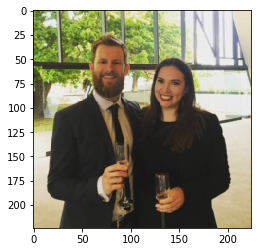

In [206]:
content_tfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

content_img_name = "mia-ben.jpg" # we use this variable later
content_img_path = "data/content/"
full_content_path = content_img_path + content_img_name

content_features, content_img, content_hooks = target_content(
    full_content_path, 
    content_tfm, 
    vgg, 
    [7] 
    # deeper (higher indexed) layers will generally lead to images whose content is further from the example content image
)

content_features = content_features[0]
content_hook = content_hooks[0]

img.show_image(content_img)

In [216]:
pyramid_height = 3

style_tfm = transforms.Compose([
    transforms.RandomResizedCrop(400),
    transforms.ToTensor(),
])

style_img_path = "data/style/"
style_img_name = "pencil-4.jpg" # we use this variable later
full_style_image_path = style_img_path + style_img_name


# Swap in th commented bits below below for vanilla texture transfer
style_feature_pyr, style_hooks, style_pyr = target_style_pyramid(
    full_style_image_path,
    3,
    style_tfm, 
    vgg,
    [5, 13], # reccomended layers for pyramid style transfer
    # [1, 3, 6, 8, 11] # << reccomended layers for vanilla style transfer
    pyramid_height = pyramid_height,
    # pyramid_height = 0
)

for i in range(len(style_pyr)):
    save_image(style_pyr[i], "data/kek{}.jpg".format(i))

## Final cell

Feel free to play around with the parameters here. The most important thing I found was keeping the `"style_scale"` higher than 100,000. 

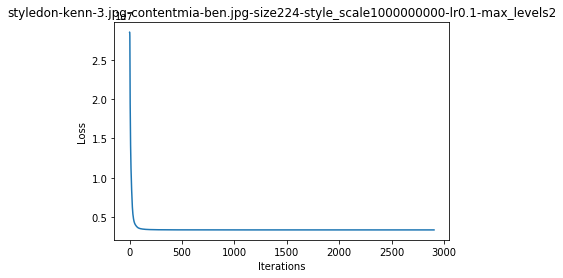

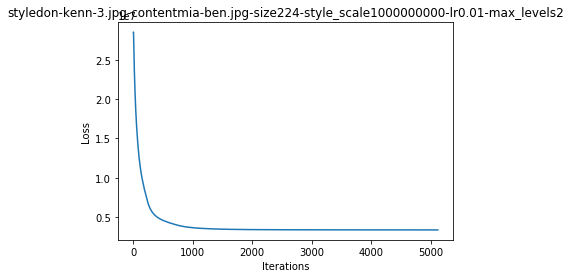

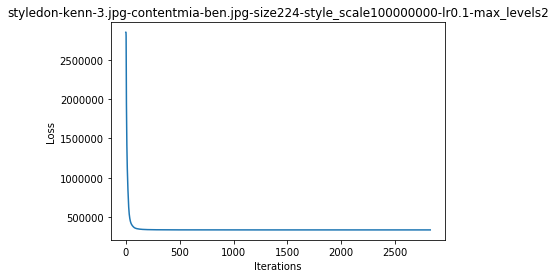

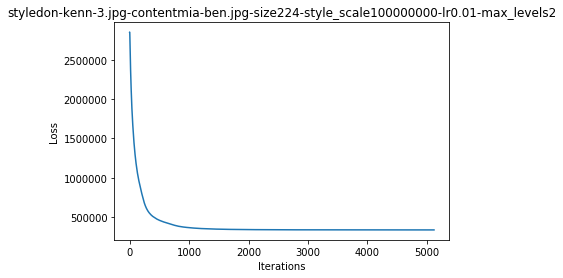

In [205]:
importlib.reload(img)

opt_tfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

params = {
    # "image": opt_img,
    "style": style_img_name,
    "content": content_img_name,
    "size": 224,
    "iterations": 256,
    "style_scale": 100000,
    "model": vgg,
    "style_hooks": style_hooks,
    "content_hook": content_hook,
    "lr": 0.1,
    "max_levels": pyramid_height,
}

meta_params = {
    "save_mode": "throughout" ,
    "style_feature_pyr": style_feature_pyr,
    "content_features": content_features,
    # determine whether to save just the final image, or save at intervals while generating
}

syn = Transferrer(meta_params)

for s in [1000000000, 100000000]:
    for lr in [0.1, 0.01]:
        params["image"] = img.image_loader(full_content_path, opt_tfm, requires_grad=True)
        params["lr"] = lr
        params["style_scale"] = s
        params["id"] = identifier(params) 

        _, losses = syn.transfer(params)
        
        plt.figure()
        plt.title(params["id"])
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.plot(losses)

In [213]:
from torchvision.utils import save_image
save_image(img.random_image(6, 500), "data/kek.jpg")